# 深度学习—使用Keras构建猫/狗分类器

## 导入必要的包

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook
from random import shuffle
import shutil

%matplotlib inline

## 重头构建一个卷积神经网络

在第一部分中，我们将建立一个端到端的模型来训练卷积神经网络。我们将通过数据准备和扩充、架构设计、训练和验证。我们将在训练集和验证集上绘制损失和准确性度量：这将允许我们对模型在训练中的改进进行评估。

### 数据集划分

现在我们必须对数据进行合理的组织和划分，以便很容易地被Keras进行处理。

我们将创建一个数据文件夹`data`，其中有两个子文件夹：

- train
- validation

这两个子目录又分别包含两个子文件夹：

- cats
- dogs
    

这种结构将允许我们的模型知道从哪个文件夹获取图像以及用于训练或验证的图像标签。

其中，`organize_datasets`函数允许你构造这个文件树结构。它包含两个参数：图像总数目`N`和验证集的比率`r`。

In [2]:
def organize_datasets(path_to_data, n, ratio):
    files = os.listdir(path_to_data)
    files = [os.path.join(path_to_data, f) for f in files]
    shuffle(files)
    files = files[:n]
    
    n = int(len(files) * ratio)
    val, train = files[:n], files[n:]
    

    shutil.rmtree('./data/')
    print('/data/ removed')

    for c in ['dogs', 'cats']: 
        os.makedirs('./data/train/{0}/'.format(c))
        os.makedirs('./data/validation/{0}/'.format(c))

    print('folders created !')

    for t in tqdm_notebook(train):
        if 'cat' in t:
            shutil.copy2(t, os.path.join('.', 'data', 'train', 'cats'))
        else:
            shutil.copy2(t, os.path.join('.', 'data', 'train', 'dogs'))
     
    for v in tqdm_notebook(val):
        if 'cat' in v:
            shutil.copy2(v, os.path.join('.', 'data', 'validation', 'cats'))
        else:
            shutil.copy2(v, os.path.join('.', 'data', 'validation', 'dogs'))
            
    print('Data copied!')

In [3]:
ratio = 0.2
n = 1000
organize_datasets(path_to_data='./train/', n=n, ratio=ratio)

/data/ removed
folders created !



Data copied!


### 导入Keras和加载TensorFlow

我们使用深度学习框架[Keras](https://keras.io/)来训练我们的卷积神经网络模型，同时使用[TensorFow](https://www.tensorflow.org/)作为Keras的后端。因此，我们需要首先导入Keras相关的包。

In [4]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 图像生成和图像扩充

通常，在训练模型时，我们不会将整个数据集加载到内存中。这样做效率不高，特别是如果你使用本地机器的话。

我们将使用Keras提供的`ImageDataGenerator`类。它允许Keras从训练和验证文件夹中按照批量无限地读取图像。

每个批处理图像流经卷积神经网络，进行前向传播和反向传播，然后更新参数（以及对验证数据的测试）。然后是下一批量图像，做同样的事情，等等。


在`ImageDataGenerator`对象中，我们将在每个图像批次上引入随机修改。这是一个我们称之为数据扩充的过程。它允许生成更多的数据，使我们的模型永远不会看到两次完全相同的图片。这有助于防止过拟合，并使模型具有更好的泛化性。

我们将创建两个图像生成器对象。`train_datagen `用于训练集和`val_datagen`用于验证集。这两个图像生成对象将在图像上应用缩放变换，并且`train_datagen`将引入更多的图像变换操作。

In [5]:
batch_size = 32

In [6]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True
                                    )
val_datagen = ImageDataGenerator(rescale=1/255.0)

In [7]:
train_generator = train_datagen.flow_from_directory(
        './data/train/',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        './data/validation/',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### 创建卷积神经网络

我们将创建一个具有三个卷积/池化层和两个全连接层的卷积神经网络。

第一个卷积层包含32个滤波器，每个滤波器大小为3x3；

第二个卷积层包含32个滤波器，每个滤波器大小为3x3；

第三个卷积层包含64个滤波器，每个滤波器大小为3x3。

激活函数使用`ReLU`。

我们还在两个全连接层上使用了`Dropout`层，以防止过拟合。

In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

### 随机梯度下降优化

我们使用随即梯度下降对损失函数进行优化，初始学习率为0.01，动量为0.9。

因为这是一个二分类问题，因此损失函数为`binary crossentropy`。

In [9]:
epochs = 20 # For GPU set epochs = 50
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

### 显示模型结构

通过模型对象的`summary`方法可以对构建的卷积神经网络模型进行显示。

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 64)        0         
__________

### 模型可视化

![模型](./model.png)

### 训练模型

在训练模型之前，我们定义了两个回调函数，这些函数将在训练时被Keras调用。

- 一种用于当损失函数停止改进验证数据时提前停止训练

- 一个用于存储每个批次的验证损失和精度：这允许我们在训练完成绘制训练误差。

In [11]:
## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
history = LossHistory()

## Callback for early stopping the training
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0,
                              mode='auto')

我们还使用了`keras-tqdm`包。这个是一个非常棒用于显示进度条的Python库，可以与Keras完美地结合在一起。

使用`Keras-tqdm`允许我们非常容易地监控整个模型的训练。

我们所需要做的只是从`keras-tqdm`包加载`TQDMNotebookCallback`类，然后将其作为第三个回调函数传递。

关于训练值得注意的几点：

- 我们将使用`fit_generator`生成器方法（[中文说明](https://keras-cn.readthedocs.io/en/latest/models/sequential/)），该方法是标准拟合方法`fit`的变体，接收一个生成器作为参数。

- 我们将模型训练20轮：在每一轮中，每一个批次大小为32，执行前向和反向传播，并使用随即梯度下降调整权重。

- epochs是一个可以调整的参数，如果在GPU上面运行，建议设置为50；如果在CPU上运行，设置为50则会需要较长的运行时间。

In [12]:
fitted_model = model.fit_generator(
        train_generator,
        steps_per_epoch= int(n * (1-ratio)) // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps= int(n * ratio) // batch_size,
        callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True), early_stopping, history],
        verbose=0)

### 保存模型

训练完成以后，可以将模型保存到本地，以便后续需要时可以重新加载。

In [13]:
model.save('./models/model4.h5')

### 损失可视化

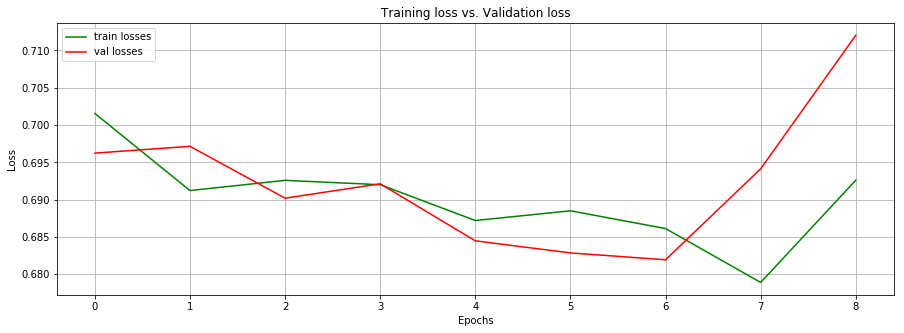

In [14]:
losses, val_losses = history.losses, history.val_losses
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['loss'], 'g', label="train losses")
plt.plot(fitted_model.history['val_loss'], 'r', label="val losses")
plt.grid(True)
plt.title('Training loss vs. Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### 精度可视化

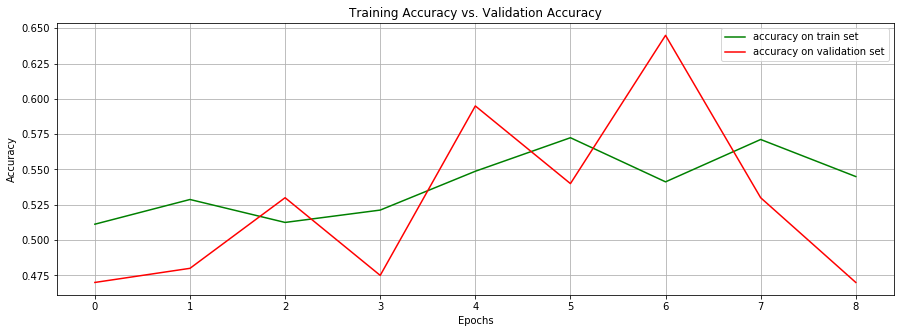

In [15]:
losses, val_losses = history.losses, history.val_losses
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['acc'], 'g', label="accuracy on train set")
plt.plot(fitted_model.history['val_acc'], 'r', label="accuracy on validation set")
plt.grid(True)
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## 迁移学习

到目前为止，我们设计了一个定制的卷积神经网络，它可以对已有的数据进行分类。

然而，有一种方法可以得到更好的精度：使用在一个大数据集上（ImageNet）预训练的卷积神经网络的权重，该数据集包括1000个类别，其中也包括猫和狗的图像。这样的网络学习到的特征与我们的分类的特征是相关的。

我们将加载VGG16网络的权重：更具体地说，我们将提取VGG16网络的所有卷积层特征。即，这个网络充当一个特征检测器。然后我们将为我们的分类任务添加全连接层。

和LeNet5相比，VGG16是一个非常大的网络。它一共有16层，大约1.4亿个可训练的参数。要了解更多关于VGG16的知识，请参阅此[PDF链接](https://arxiv.org/pdf/1409.1556.pdf)。

VGG16模型结构如下图所示：

![VGG16](./vgg16.png)

### 加载预训练模型

我们首先加载VGG16权重（在ImageNet上训练），并且指定忽略VGG16最后的三个全连阶层（设定参数`include_top=False`）。

In [16]:
from keras import applications
# include_top: whether to include the 3 fully-connected layers at the top of the network.
model = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1.0 / 255)

58892288/58889256 [==============================] - ETA: 34:3 - ETA: 13:5 - ETA: 8:4 - ETA: 7: - ETA: 6: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 34s - ETA: 32 - ETA: 28 - ETA: 24 - ETA: 24 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 17 - ETA: 17 - ETA: 14 - ETA: 14 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 9 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 10s 0us/step


In [17]:
generator = datagen.flow_from_directory('./data/train/',
                                        target_size=(150, 150),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

bottleneck_features_train = model.predict_generator(generator, int(n * (1 - ratio)) // batch_size)
np.save(open('./features/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

Found 800 images belonging to 2 classes.


In [18]:
generator = datagen.flow_from_directory('./data/validation/',
                                        target_size=(150, 150),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

bottleneck_features_validation = model.predict_generator(generator, int(n * ratio) // batch_size,)
np.save('./features/bottleneck_features_validation.npy', bottleneck_features_validation)

Found 200 images belonging to 2 classes.


### 标签

现在我们加载前面保存的特征，并为每一个样本添加标签。因为图像的次序已经确定，所以标签的添加就相对比较容易。

In [19]:
train_data = np.load('./features/bottleneck_features_train.npy')
train_labels = np.array([0] * (int((1-ratio) * n) // 2) + [1] * (int((1 - ratio) * n) // 2))
print(train_data.shape[1:])
validation_data = np.load('./features/bottleneck_features_validation.npy')
validation_labels = np.array([0] * (int(ratio * n) // 2) + [1] * (int(ratio * n) // 2))

(4, 4, 512)


### 添加新的全连阶层

现在我们设计一个小型的全连接网络，添加到到从VGG16提取的特征后面，作为卷积神经网络的分类器。

In [20]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

### 训练模型

In [21]:
fitted_model = model.fit(train_data, train_labels,
          epochs=15,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels[:validation_data.shape[0]]),
          verbose=0,
          callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=False), history])

### 损失函数可视化

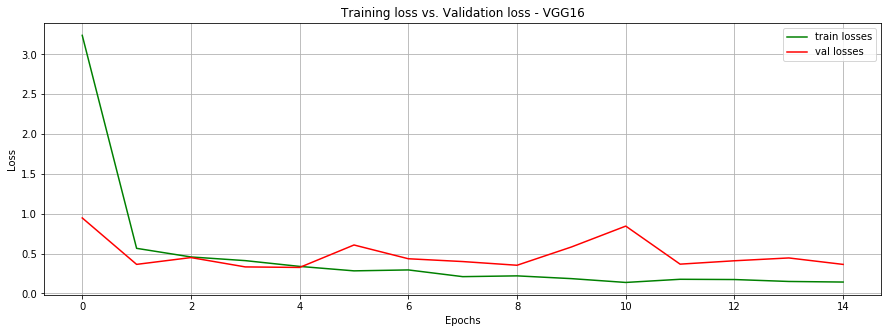

In [22]:
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['loss'], 'g', label="train losses")
plt.plot(fitted_model.history['val_loss'], 'r', label="val losses")
plt.grid(True)
plt.title('Training loss vs. Validation loss - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### 精度可视化

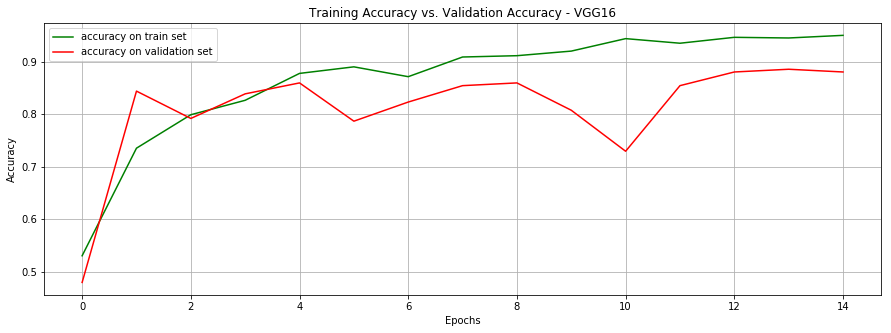

In [23]:
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['acc'], 'g', label="accuracy on train set")
plt.plot(fitted_model.history['val_acc'], 'r', label="accuracy on validation set")
plt.grid(True)
plt.title('Training Accuracy vs. Validation Accuracy - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## print('Hello')